## **🔧 Part 3: Feature Engineering & Encoding**

# Table of Contents

1. [Feature Engineering](#feature-engineering)
2. [Encoding Categorical Variables](#encoding-categorical-variables)
3. [Feature Scaling](#feature-scaling)
4. [Feature Selection](#feature-selection)





# **1. Feature Engineering**

# **📚 Setup**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load cleaned data
df = pd.read_csv('data_cleaned.csv')

print("="*80)
print("FEATURE ENGINEERING")
print("="*80)
print(f"Starting with {len(df)} rows and {len(df.columns)} columns\n")

FEATURE ENGINEERING
Starting with 6716 rows and 36 columns



# **Step 1: Create Interaction Features**


💡 **Why Interaction Features?**

- **Capture relationships** — Some features work together
- **Non-linear patterns** — Models can't always discover these automatically
- **Domain knowledge** — Use business understanding to create meaningful features


In [2]:
print("="*80)
print("STEP 1: CREATE INTERACTION FEATURES")
print("="*80)

# 1. Average Charge Per Month
df['AvgChargePerMonth'] = df['TotalCharges'] / (df['tenure'] + 1)
print("✅ Created: AvgChargePerMonth")

# 2. Charges Per Service (how much they pay per service)
# Count total services
service_cols = ['PhoneService', 'InternetService', 'OnlineSecurity',
                'OnlineBackup', 'DeviceProtection', 'TechSupport',
                'StreamingTV', 'StreamingMovies']

df['TotalServices'] = 0
for col in service_cols:
    if col in df.columns:
        if col == 'PhoneService' or col == 'InternetService':
            df['TotalServices'] += (df[col] != 'No').astype(int)
        else:
            df['TotalServices'] += (df[col] == 'Yes').astype(int)

df['ChargePerService'] = df['MonthlyCharges'] / (df['TotalServices'] + 1)
print("✅ Created: ChargePerService")

# 3. Is Senior with Partner (interaction between two features)
if 'SeniorCitizen' in df.columns and 'Partner' in df.columns:
    df['SeniorWithPartner'] = ((df['SeniorCitizen'] == 1) &
                                (df['Partner'] == 'Yes')).astype(int)
    print("✅ Created: SeniorWithPartner")

# 4. Has Fiber Internet (important predictor)
if 'InternetService' in df.columns:
    df['HasFiberInternet'] = (df['InternetService'] == 'Fiber optic').astype(int)
    print("✅ Created: HasFiberInternet")

print(f"\n📊 Sample of new features:")
print(df[['AvgChargePerMonth', 'TotalServices', 'ChargePerService']].head())

STEP 1: CREATE INTERACTION FEATURES
✅ Created: AvgChargePerMonth
✅ Created: ChargePerService
✅ Created: SeniorWithPartner
✅ Created: HasFiberInternet

📊 Sample of new features:
   AvgChargePerMonth  TotalServices  ChargePerService
0          48.163151              1            24.415
1          41.869726              1            21.225
2          38.796438              1            19.670
3          42.288082              1            21.440
4          72.572055              4            14.716


# **🔧 Step 2: Create Aggregation Features**

💡 **Aggregation Features:**

- **Summarize information** — Combine multiple binary features
- **Reduce dimensionality** — One feature instead of many
- **Capture patterns** — Distinguish “power users” vs “basic users”


In [3]:
print("\n" + "="*80)
print("STEP 2: CREATE AGGREGATION FEATURES")
print("="*80)

# 1. Total Add-On Services
addon_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                  'TechSupport', 'StreamingTV', 'StreamingMovies']

df['TotalAddonServices'] = 0
for col in addon_services:
    if col in df.columns:
        df['TotalAddonServices'] += (df[col] == 'Yes').astype(int)

print(f"✅ Created: TotalAddonServices")
print(f"   Distribution: {df['TotalAddonServices'].value_counts().sort_index().to_dict()}")

# 2. Has Any Add-On Service
df['HasAnyAddon'] = (df['TotalAddonServices'] > 0).astype(int)
print(f"✅ Created: HasAnyAddon")

# 3. Service Adoption Rate (percentage of available services used)
max_services = 8  # Total possible services
df['ServiceAdoptionRate'] = df['TotalServices'] / max_services
print(f"✅ Created: ServiceAdoptionRate")


STEP 2: CREATE AGGREGATION FEATURES
✅ Created: TotalAddonServices
   Distribution: {0: 1890, 1: 1362, 2: 1773, 3: 1153, 4: 441, 5: 90, 6: 7}
✅ Created: HasAnyAddon
✅ Created: ServiceAdoptionRate


# **🔧 Step 3: Create Binning Features**

💡 **Binning Benefits:**

- **Handle non-linearity** — Capture threshold effects
- **Reduce noise** — Group similar values together
- **Interpretability** — Easier to understand grouped categories
- **Helps linear models** — Tree-like behavior for continuous features


In [4]:
print("\n" + "="*80)
print("STEP 3: CREATE BINNING/DISCRETIZATION FEATURES")
print("="*80)

# 1. Tenure Groups
df['TenureGroup'] = pd.cut(df['tenure'],
                           bins=[0, 12, 24, 48, 72],
                           labels=['0-1 year', '1-2 years', '2-4 years', '4+ years'])
print("✅ Created: TenureGroup")
print(f"   Distribution:\n{df['TenureGroup'].value_counts()}\n")

# 2. Monthly Charges Groups
df['ChargeGroup'] = pd.cut(df['MonthlyCharges'],
                           bins=[0, 30, 60, 90, 150],
                           labels=['Low', 'Medium', 'High', 'Very High'])
print("✅ Created: ChargeGroup")
print(f"   Distribution:\n{df['ChargeGroup'].value_counts()}\n")

# 3. Customer Value Segment (based on total charges)
df['ValueSegment'] = pd.qcut(df['TotalCharges'],
                             q=4,
                             labels=['Bronze', 'Silver', 'Gold', 'Platinum'],
                             duplicates='drop')
print("✅ Created: ValueSegment")
print(f"   Distribution:\n{df['ValueSegment'].value_counts()}\n")


STEP 3: CREATE BINNING/DISCRETIZATION FEATURES
✅ Created: TenureGroup
   Distribution:
TenureGroup
4+ years     2334
2-4 years    2160
0-1 year     1089
1-2 years    1043
Name: count, dtype: int64

✅ Created: ChargeGroup
   Distribution:
ChargeGroup
High         3215
Medium       3053
Very High     420
Low             0
Name: count, dtype: int64

✅ Created: ValueSegment
   Distribution:
ValueSegment
Bronze      1679
Silver      1679
Gold        1679
Platinum    1679
Name: count, dtype: int64



# **🔧 Step 4: Extract Date Features**

💡 **Date Feature Engineering:**

- **Temporal patterns** — Seasonality, trends
- **Cyclical features** — Day of week, month
- **Time elapsed** — Account age, time since last contact
- **Business cycles** — Quarters, fiscal years


In [5]:
print("\n" + "="*80)
print("STEP 4: EXTRACT DATE FEATURES")
print("="*80)

# Convert date columns if they exist
if 'SignupDate' in df.columns:
    df['SignupDate'] = pd.to_datetime(df['SignupDate'], errors='coerce')

    # Extract features from SignupDate
    df['SignupYear'] = df['SignupDate'].dt.year
    df['SignupMonth'] = df['SignupDate'].dt.month
    df['SignupQuarter'] = df['SignupDate'].dt.quarter
    df['SignupDayOfWeek'] = df['SignupDate'].dt.dayofweek  # 0=Monday, 6=Sunday

    print("✅ Extracted from SignupDate:")
    print("   - SignupYear")
    print("   - SignupMonth")
    print("   - SignupQuarter")
    print("   - SignupDayOfWeek")

    # Days since signup (account age in days)
    reference_date = pd.to_datetime('2024-01-01')
    df['DaysSinceSignup'] = (reference_date - df['SignupDate']).dt.days
    print("   - DaysSinceSignup")

    print(f"\n   Sample:")
    print(df[['SignupDate', 'SignupYear', 'SignupMonth', 'DaysSinceSignup']].head())


STEP 4: EXTRACT DATE FEATURES
✅ Extracted from SignupDate:
   - SignupYear
   - SignupMonth
   - SignupQuarter
   - SignupDayOfWeek
   - DaysSinceSignup

   Sample:
  SignupDate  SignupYear  SignupMonth  DaysSinceSignup
0 2022-05-11        2022            5              600
1 2020-01-19        2020            1             1443
2 2022-02-14        2022            2              686
3 2022-04-06        2022            4              635
4 2019-04-29        2019            4             1708


# **🔧 Step 5: Create Polynomial Features (for specific features)**

💡 **Polynomial Features:**

- **Non-linear relationships** — Captures curves, not just straight lines
- **Feature interactions** — Creates combinations (e.g., `x1 * x2`, `x1²`)
- **Careful usage** — Too many polynomial terms can cause overfitting


In [6]:
print("\n" + "="*80)
print("STEP 5: CREATE POLYNOMIAL FEATURES")
print("="*80)

# Create squared features for important continuous variables
# This helps capture non-linear relationships

df['tenure_squared'] = df['tenure'] ** 2
print("✅ Created: tenure_squared")

df['MonthlyCharges_squared'] = df['MonthlyCharges'] ** 2
print("✅ Created: MonthlyCharges_squared")

# Interaction: tenure × MonthlyCharges
df['tenure_x_MonthlyCharges'] = df['tenure'] * df['MonthlyCharges']
print("✅ Created: tenure_x_MonthlyCharges")

print(f"\n📊 Polynomial features summary:")
print(df[['tenure', 'tenure_squared', 'MonthlyCharges',
         'MonthlyCharges_squared', 'tenure_x_MonthlyCharges']].describe())


STEP 5: CREATE POLYNOMIAL FEATURES
✅ Created: tenure_squared
✅ Created: MonthlyCharges_squared
✅ Created: tenure_x_MonthlyCharges

📊 Polynomial features summary:
            tenure  tenure_squared  MonthlyCharges  MonthlyCharges_squared  \
count  6716.000000     6716.000000     6688.000000             6688.000000   
mean     36.782013     1805.460989       61.480268             4081.303255   
std      21.274677     1590.472079       17.364475             2136.380370   
min       0.000000        0.000000       30.480000              929.030400   
25%      18.000000      324.000000       47.925000             2296.805700   
50%      38.000000     1444.000000       62.320000             3883.782400   
75%      56.000000     3136.000000       74.430000             5539.824900   
max      72.000000     5184.000000       91.770000             8421.732900   

       tenure_x_MonthlyCharges  
count              6688.000000  
mean               2257.895828  
std                1497.812462  
mi

# **🔧 Step 6: Create Ratio Features**

In [7]:
print("\n" + "="*80)
print("STEP 6: CREATE RATIO FEATURES")
print("="*80)

# 1. Charge Increase Rate (how much monthly charges increased over time)
df['ChargeIncreaseRate'] = (df['MonthlyCharges'] /
                            (df['TotalCharges'] / (df['tenure'] + 1) + 1))
print("✅ Created: ChargeIncreaseRate")

# 2. Service Value Ratio (services per dollar)
df['ServiceValueRatio'] = df['TotalServices'] / (df['MonthlyCharges'] + 1)
print("✅ Created: ServiceValueRatio")

print(f"\n📊 Sample:")
print(df[['ChargeIncreaseRate', 'ServiceValueRatio']].head())


STEP 6: CREATE RATIO FEATURES
✅ Created: ChargeIncreaseRate
✅ Created: ServiceValueRatio

📊 Sample:
   ChargeIncreaseRate  ServiceValueRatio
0            0.993224           0.020068
1            0.990209           0.023015
2            0.988531           0.024789
3            0.990573           0.022789
4            1.000108           0.053634


# **📊 Summary of Feature Engineering**

In [8]:
print("\n" + "="*80)
print("FEATURE ENGINEERING SUMMARY")
print("="*80)

original_features = ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
                    'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
                    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                    'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
                    'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

engineered_features = [col for col in df.columns if col not in original_features]

print(f"Original features: {len(original_features)}")
print(f"Engineered features: {len(engineered_features)}")
print(f"Total features: {len(df.columns)}")

print(f"\n📝 New features created:")
for feat in engineered_features:
    print(f"   • {feat}")

# Save data with engineered features
df.to_csv('data_with_features.csv', index=False)
print(f"\n✅ Data saved as 'data_with_features.csv'")


FEATURE ENGINEERING SUMMARY
Original features: 21
Engineered features: 36
Total features: 57

📝 New features created:
   • SignupDate
   • LastContactDate
   • NumServiceTickets
   • NumTechTickets
   • NumAdminTickets
   • CustomerSatisfactionScore
   • DownloadSpeed
   • UploadSpeed
   • ContractRenewals
   • City
   • Region
   • AccountAgeYears
   • TotalServicesUsed
   • AvgChargePerService
   • PaymentDelay
   • AvgChargePerMonth
   • TotalServices
   • ChargePerService
   • SeniorWithPartner
   • HasFiberInternet
   • TotalAddonServices
   • HasAnyAddon
   • ServiceAdoptionRate
   • TenureGroup
   • ChargeGroup
   • ValueSegment
   • SignupYear
   • SignupMonth
   • SignupQuarter
   • SignupDayOfWeek
   • DaysSinceSignup
   • tenure_squared
   • MonthlyCharges_squared
   • tenure_x_MonthlyCharges
   • ChargeIncreaseRate
   • ServiceValueRatio

✅ Data saved as 'data_with_features.csv'


# **2. Encoding Categorical Variables**

# **📚 Understanding Encoding Types**

In [9]:
print("\n" + "="*80)
print("ENCODING CATEGORICAL VARIABLES")
print("="*80)

# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'customerID']

print(f"Categorical columns to encode: {len(categorical_cols)}")
for col in categorical_cols:
    print(f"   • {col}: {df[col].nunique()} unique values")


ENCODING CATEGORICAL VARIABLES
Categorical columns to encode: 22
   • gender: 2 unique values
   • Partner: 2 unique values
   • Dependents: 2 unique values
   • PhoneService: 2 unique values
   • MultipleLines: 3 unique values
   • InternetService: 3 unique values
   • OnlineSecurity: 3 unique values
   • OnlineBackup: 3 unique values
   • DeviceProtection: 3 unique values
   • TechSupport: 3 unique values
   • StreamingTV: 3 unique values
   • StreamingMovies: 3 unique values
   • Contract: 3 unique values
   • PaperlessBilling: 2 unique values
   • PaymentMethod: 4 unique values
   • Churn: 2 unique values
   • LastContactDate: 2736 unique values
   • City: 24 unique values
   • Region: 4 unique values
   • TenureGroup: 4 unique values
   • ChargeGroup: 3 unique values
   • ValueSegment: 4 unique values


# **🔢 Step 1: Binary Encoding (for binary features)**

💡 **Binary Encoding:**

- **Simple and efficient** — Just two values
- **No extra dimensions** — Only one column needed
- **Interpretable** — Easy to understand (`0 = No`, `1 = Yes`)


In [10]:
print("\n" + "="*80)
print("STEP 1: BINARY ENCODING")
print("="*80)

# Binary features: Features with only 2 unique values
binary_features = ['gender', 'Partner', 'Dependents', 'PhoneService',
                   'PaperlessBilling']

for col in binary_features:
    if col in df.columns:
        print(f"\n{col}:")
        print(f"   Before: {df[col].unique()}")

        # Map to 0 and 1
        if col == 'gender':
            df[col + '_encoded'] = df[col].map({'Female': 0, 'Male': 1})
        else:
            df[col + '_encoded'] = df[col].map({'No': 0, 'Yes': 1})

        print(f"   After: {df[col + '_encoded'].unique()}")
        print(f"   ✅ Encoded as 0/1")


STEP 1: BINARY ENCODING

gender:
   Before: ['Male' 'Female']
   After: [1 0]
   ✅ Encoded as 0/1

Partner:
   Before: ['No' 'Yes']
   After: [0 1]
   ✅ Encoded as 0/1

Dependents:
   Before: ['No' 'Yes']
   After: [0 1]
   ✅ Encoded as 0/1

PhoneService:
   Before: ['Yes' 'No']
   After: [1 0]
   ✅ Encoded as 0/1

PaperlessBilling:
   Before: ['Yes' 'No']
   After: [1 0]
   ✅ Encoded as 0/1


In [11]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,tenure_squared,MonthlyCharges_squared,tenure_x_MonthlyCharges,ChargeIncreaseRate,ServiceValueRatio,gender_encoded,Partner_encoded,Dependents_encoded,PhoneService_encoded,PaperlessBilling_encoded
0,1092-KIO,Male,0,No,No,72,Yes,Yes,No,No internet service,...,5184,2384.3689,3515.76,0.993224,0.020068,1,0,0,1,1
1,5379-KIO,Male,0,Yes,No,72,Yes,Yes,No,No internet service,...,5184,1802.0025,3056.40,0.990209,0.023015,1,1,0,1,1
2,6633-CFO,Female,0,No,No,72,Yes,Yes,No,No internet service,...,5184,1547.6356,2832.48,0.988531,0.024789,0,0,0,1,1
3,8004-VHV,Female,0,No,No,72,Yes,No,No,No internet service,...,5184,1838.6944,3087.36,0.990573,0.022789,0,0,0,1,1
4,1418-GNV,Male,0,No,No,72,Yes,No,DSL,No,...,5184,5414.0164,5297.76,1.000108,0.053634,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6711,6152-KIO,Female,0,Yes,No,0,Yes,No,Fiber optic,No,...,0,4083.2100,0.00,63.900000,0.046225,0,1,0,1,1
6712,7834-QPY,Male,0,No,Yes,0,Yes,No,DSL,Yes,...,0,4638.9721,0.00,68.110000,0.072348,1,0,1,1,1
6713,9524-HQI,Female,1,No,No,0,Yes,No,Fiber optic,No,...,0,1610.4169,0.00,40.130000,0.048626,0,0,0,1,1
6714,5809-OKO,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,0,7133.4916,0.00,84.460000,0.058507,0,1,1,1,1


# **🏷️ Step 2: Label Encoding (for ordinal features)**

💡 **Label Encoding:**

- **Preserves order** — Good for ordinal data (`low < medium < high`)
- **Single column** — No dimensional explosion
- ⚠️ **Warning** — Only use when order makes sense!


In [12]:
print("\n" + "="*80)
print("STEP 2: LABEL ENCODING (Ordinal Features)")
print("="*80)

from sklearn.preprocessing import LabelEncoder

# Contract has natural ordering: Month-to-month < One year < Two year
if 'Contract' in df.columns:
    print("\nContract (Ordinal - has natural order):")
    print(f"   Before: {df['Contract'].unique()}")

    # Manual mapping to preserve order
    contract_mapping = {
        'Month-to-month': 0,
        'One year': 1,
        'Two year': 2
    }
    df['Contract_encoded'] = df['Contract'].map(contract_mapping)

    print(f"   After: {df['Contract_encoded'].unique()}")
    print(f"   Mapping: {contract_mapping}")
    print("   ✅ Label encoded with order preserved")


STEP 2: LABEL ENCODING (Ordinal Features)

Contract (Ordinal - has natural order):
   Before: ['One year' 'Month-to-month' 'Two year']
   After: [1 0 2]
   Mapping: {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
   ✅ Label encoded with order preserved


In [13]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,MonthlyCharges_squared,tenure_x_MonthlyCharges,ChargeIncreaseRate,ServiceValueRatio,gender_encoded,Partner_encoded,Dependents_encoded,PhoneService_encoded,PaperlessBilling_encoded,Contract_encoded
0,1092-KIO,Male,0,No,No,72,Yes,Yes,No,No internet service,...,2384.3689,3515.76,0.993224,0.020068,1,0,0,1,1,1
1,5379-KIO,Male,0,Yes,No,72,Yes,Yes,No,No internet service,...,1802.0025,3056.40,0.990209,0.023015,1,1,0,1,1,0
2,6633-CFO,Female,0,No,No,72,Yes,Yes,No,No internet service,...,1547.6356,2832.48,0.988531,0.024789,0,0,0,1,1,2
3,8004-VHV,Female,0,No,No,72,Yes,No,No,No internet service,...,1838.6944,3087.36,0.990573,0.022789,0,0,0,1,1,1
4,1418-GNV,Male,0,No,No,72,Yes,No,DSL,No,...,5414.0164,5297.76,1.000108,0.053634,1,0,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6711,6152-KIO,Female,0,Yes,No,0,Yes,No,Fiber optic,No,...,4083.2100,0.00,63.900000,0.046225,0,1,0,1,1,0
6712,7834-QPY,Male,0,No,Yes,0,Yes,No,DSL,Yes,...,4638.9721,0.00,68.110000,0.072348,1,0,1,1,1,1
6713,9524-HQI,Female,1,No,No,0,Yes,No,Fiber optic,No,...,1610.4169,0.00,40.130000,0.048626,0,0,0,1,1,1
6714,5809-OKO,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,7133.4916,0.00,84.460000,0.058507,0,1,1,1,1,1


# **🎯 Step 3: One-Hot Encoding (for nominal features)**

💡 **One-Hot Encoding:**

- **No ordering assumption** — Perfect for nominal data (categories with no order)
- **Each category gets a column** — Creates binary columns
- **Drop first** — Prevents multicollinearity (`k - 1` columns for `k` categories)
- ⚠️ **Warning** — Can create too many columns with high-cardinality features


In [16]:
print("\n" + "="*80)
print("STEP 3: ONE-HOT ENCODING (Nominal Features)")
print("="*80)

# Nominal features: No natural ordering
nominal_features = ['InternetService', 'PaymentMethod']

for col in nominal_features:
    if col in df.columns and df[col].nunique() <= 5:  # Only if few categories
        print(f"\n{col}:")
        print(f"   Categories: {df[col].unique()}")
        print(f"   Number of categories: {df[col].nunique()}")

        # Create dummy variables with dtype=int (FIX HERE!)
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True, dtype=int)

        print(f"   Created {len(dummies.columns)} dummy columns:")
        for dummy_col in dummies.columns:
            print(f"      • {dummy_col}")

        # Add to dataframe
        df = pd.concat([df, dummies], axis=1)

        print(f"   ✅ One-hot encoded (as 0/1)")

print(f"\n📊 Dataset shape after one-hot encoding: {df.shape}")


STEP 3: ONE-HOT ENCODING (Nominal Features)

InternetService:
   Categories: ['No' 'DSL' 'Fiber optic']
   Number of categories: 3
   Created 2 dummy columns:
      • InternetService_Fiber optic
      • InternetService_No
   ✅ One-hot encoded (as 0/1)

PaymentMethod:
   Categories: ['Bank transfer (automatic)' 'Credit card (automatic)' 'Mailed check'
 'Electronic check']
   Number of categories: 4
   Created 3 dummy columns:
      • PaymentMethod_Credit card (automatic)
      • PaymentMethod_Electronic check
      • PaymentMethod_Mailed check
   ✅ One-hot encoded (as 0/1)

📊 Dataset shape after one-hot encoding: (6716, 73)


In [17]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,InternetService_Fiber optic,InternetService_No,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1092-KIO,Male,0,No,No,72,Yes,Yes,No,No internet service,...,False,True,False,False,False,0,1,0,0,0
1,5379-KIO,Male,0,Yes,No,72,Yes,Yes,No,No internet service,...,False,True,True,False,False,0,1,1,0,0
2,6633-CFO,Female,0,No,No,72,Yes,Yes,No,No internet service,...,False,True,False,False,True,0,1,0,0,1
3,8004-VHV,Female,0,No,No,72,Yes,No,No,No internet service,...,False,True,True,False,False,0,1,1,0,0
4,1418-GNV,Male,0,No,No,72,Yes,No,DSL,No,...,False,False,True,False,False,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6711,6152-KIO,Female,0,Yes,No,0,Yes,No,Fiber optic,No,...,True,False,True,False,False,1,0,1,0,0
6712,7834-QPY,Male,0,No,Yes,0,Yes,No,DSL,Yes,...,False,False,False,False,False,0,0,0,0,0
6713,9524-HQI,Female,1,No,No,0,Yes,No,Fiber optic,No,...,True,False,False,False,True,1,0,0,0,1
6714,5809-OKO,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,False,False,False,False,True,0,0,0,0,1


# **🎨 Step 4: Frequency Encoding (for high cardinality features)**

💡 **Frequency Encoding:**

- **Handles high cardinality** — Works with many categories
- **Single column** — No dimension explosion
- **Captures popularity** — Frequent categories get higher values
- **Information preserved** — Maintains statistical relationships


In [18]:
print("\n" + "="*80)
print("STEP 4: FREQUENCY ENCODING (High Cardinality)")
print("="*80)

# For features with many categories (like City)
high_cardinality_features = ['City']

for col in high_cardinality_features:
    if col in df.columns:
        print(f"\n{col}:")
        print(f"   Unique values: {df[col].nunique()}")

        # Calculate frequency of each category
        freq = df[col].value_counts() / len(df)

        # Map to dataframe
        df[col + '_freq'] = df[col].map(freq)

        print(f"   ✅ Frequency encoded")
        print(f"   Sample:")
        print(df[[col, col + '_freq']].head())


STEP 4: FREQUENCY ENCODING (High Cardinality)

City:
   Unique values: 24
   ✅ Frequency encoded
   Sample:
           City  City_freq
0      Portland   0.038714
1   San Antonio   0.043627
2  Philadelphia   0.041096
3    Fort Worth   0.040649
4        Austin   0.040947


# **🎯 Step 5: Target Encoding (for important features)**

💡 **Target Encoding:**

- **Captures relationship with target** — Uses target variable information
- **Single column** — Efficient
- ⚠️ **CRITICAL** — Must use cross-validation to avoid data leakage!
- **Risk of overfitting** — Can memorize training data


In [19]:
print("\n" + "="*80)
print("STEP 5: TARGET ENCODING")
print("="*80)

# IMPORTANT: Only use on training data to avoid data leakage!
# This is a demonstration - in practice, use with cross-validation

# Target encoding: Replace category with mean of target for that category
target_encode_features = ['PaymentMethod']

for col in target_encode_features:
    if col in df.columns and 'Churn' in df.columns:
        print(f"\n{col}:")

        # Calculate mean churn rate for each category
        target_mean = df.groupby(col)['Churn'].apply(
            lambda x: (x == 'Yes').sum() / len(x)
        )

        print(f"   Churn rate by {col}:")
        print(target_mean)

        # Map to dataframe
        df[col + '_target'] = df[col].map(target_mean)

        print(f"\n   ✅ Target encoded")
        print(f"   Sample:")
        print(df[[col, col + '_target', 'Churn']].head())


STEP 5: TARGET ENCODING

PaymentMethod:
   Churn rate by PaymentMethod:
PaymentMethod
Bank transfer (automatic)    0.412998
Credit card (automatic)      0.419205
Electronic check             0.543265
Mailed check                 0.407697
Name: Churn, dtype: float64

   ✅ Target encoded
   Sample:
               PaymentMethod  PaymentMethod_target Churn
0  Bank transfer (automatic)              0.412998   Yes
1    Credit card (automatic)              0.419205    No
2               Mailed check              0.407697    No
3    Credit card (automatic)              0.419205   Yes
4    Credit card (automatic)              0.419205    No


# **📊 Encoding Summary**

In [20]:
print("\n" + "="*80)
print("ENCODING SUMMARY")
print("="*80)

print("""
Encoding Method Applied To:
1. Binary Encoding → gender, Partner, Dependents, PhoneService, PaperlessBilling
2. Label Encoding → Contract (ordinal)
3. One-Hot Encoding → InternetService, PaymentMethod (low cardinality)
4. Frequency Encoding → City (high cardinality)
5. Target Encoding → PaymentMethod (demonstration)

Original categorical columns: Kept for reference
Encoded columns: Created with '_encoded', '_freq', '_target' suffixes
""")

# Save data with encoded features
df.to_csv('data_encoded.csv', index=False)
print("✅ Data saved as 'data_encoded.csv'")


ENCODING SUMMARY

Encoding Method Applied To:
1. Binary Encoding → gender, Partner, Dependents, PhoneService, PaperlessBilling
2. Label Encoding → Contract (ordinal)
3. One-Hot Encoding → InternetService, PaymentMethod (low cardinality)
4. Frequency Encoding → City (high cardinality)
5. Target Encoding → PaymentMethod (demonstration)

Original categorical columns: Kept for reference
Encoded columns: Created with '_encoded', '_freq', '_target' suffixes

✅ Data saved as 'data_encoded.csv'


# **3. Feature Scaling**

# **📊 Step 1: Identify Features to Scale**

In [21]:
print("\n" + "="*80)
print("FEATURE SCALING")
print("="*80)

# Select numerical features for scaling (exclude IDs and encoded features)
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove features that shouldn't be scaled
exclude_features = ['customerID', 'SeniorCitizen']  # Binary features don't need scaling
numerical_features = [col for col in numerical_features
                     if col not in exclude_features and '_encoded' not in col]

print(f"Features to scale ({len(numerical_features)}):")
for feat in numerical_features[:10]:  # Show first 10
    print(f"   • {feat}")

print("\n📊 Before scaling - Sample statistics:")
print(df[numerical_features[:5]].describe())


FEATURE SCALING
Features to scale (35):
   • tenure
   • MonthlyCharges
   • TotalCharges
   • NumServiceTickets
   • NumTechTickets
   • NumAdminTickets
   • CustomerSatisfactionScore
   • DownloadSpeed
   • UploadSpeed
   • ContractRenewals

📊 Before scaling - Sample statistics:
            tenure  MonthlyCharges  TotalCharges  NumServiceTickets  \
count  6716.000000     6688.000000   6716.000000        6716.000000   
mean     36.782013       61.480268   2308.662108           3.374181   
std      21.274677       17.364475   1785.681708           2.352695   
min       0.000000       30.480000      0.000000           0.000000   
25%      18.000000       47.925000   1015.645000           2.000000   
50%      38.000000       62.320000   2061.445000           3.000000   
75%      56.000000       74.430000   3352.875000           5.000000   
max      72.000000       91.770000  24982.321319          15.000000   

       NumTechTickets  
count     6716.000000  
mean         2.410661  
std  

# **🔧 Step 2: Standard Scaling (Standardization)**

## 🧪 Step 2: Standard Scaling (Standardization)

Standard Scaling (or Standardization) transforms numerical features so that they have:

- **Mean = 0**  
- **Standard deviation = 1**

**How it works:**  
Each value \(x\) in a feature is transformed into a standardized value \(z\) using the formula:

\[
z = \frac{x - \mu}{\sigma}
\]

Where:  
- \(x\) = original feature value  
- \(\mu\) = mean of the feature  
- \(\sigma\) = standard deviation of the featur

💡 **When to Use Standard Scaling:**

✅ Logistic Regression  
✅ Support Vector Machines (SVM)  
✅ Neural Networks  
✅ K-Nearest Neighbors (KNN)  
✅ Principal Component Analysis (PCA)


In [22]:
print("\n" + "="*80)
print("STEP 2: STANDARD SCALING (Standardization)")
print("="*80)

from sklearn.preprocessing import StandardScaler

# Create a copy for demonstration
df_standard = df.copy()

# Initialize scaler
standard_scaler = StandardScaler()

# Fit and transform
df_standard[numerical_features] = standard_scaler.fit_transform(df[numerical_features])

print("✅ Standard Scaling applied")
print("\n📊 After standard scaling:")
print(df_standard[numerical_features[:5]].describe())

print("""
💡 Standard Scaling (Z-score normalization):
   Formula: z = (x - μ) / σ
   Result: Mean = 0, Std Dev = 1
   Use for: Algorithms that assume normal distribution (SVM, Logistic Regression, Neural Networks)
""")


STEP 2: STANDARD SCALING (Standardization)
✅ Standard Scaling applied

📊 After standard scaling:
             tenure  MonthlyCharges  TotalCharges  NumServiceTickets  \
count  6.716000e+03    6.688000e+03  6.716000e+03       6.716000e+03   
mean   6.771104e-17   -6.055762e-17 -1.354221e-16       1.269582e-17   
std    1.000074e+00    1.000075e+00  1.000074e+00       1.000074e+00   
min   -1.729039e+00   -1.785403e+00 -1.292971e+00      -1.434284e+00   
25%   -8.829000e-01   -7.806905e-01 -7.241567e-01      -5.841316e-01   
50%    5.725481e-02    4.836281e-02 -1.384544e-01      -1.590555e-01   
75%    9.033941e-01    7.458158e-01  5.848134e-01       6.910969e-01   
max    1.655518e+00    1.744481e+00  1.269843e+01       4.941859e+00   

       NumTechTickets  
count    6.716000e+03  
mean    -1.481179e-17  
std      1.000074e+00  
min     -1.329108e+00  
25%     -7.777621e-01  
50%     -2.264163e-01  
75%      3.249295e-01  
max      5.287042e+00  

💡 Standard Scaling (Z-score normaliz

# **🔧 Step 3: Min-Max Scaling (Normalization)**

💡 **When to Use Min-Max Scaling:**

✅ Neural Networks (bounded activation functions)  
✅ K-Nearest Neighbors  
✅ Image processing  
⚠️ NOT recommended if outliers are present


In [23]:
print("\n" + "="*80)
print("STEP 3: MIN-MAX SCALING (Normalization)")
print("="*80)

from sklearn.preprocessing import MinMaxScaler

# Create a copy for demonstration
df_minmax = df.copy()

# Initialize scaler
minmax_scaler = MinMaxScaler()

# Fit and transform
df_minmax[numerical_features] = minmax_scaler.fit_transform(df[numerical_features])

print("✅ Min-Max Scaling applied")
print("\n📊 After min-max scaling:")
print(df_minmax[numerical_features[:5]].describe())

print("""
💡 Min-Max Scaling:
   Formula: x_scaled = (x - x_min) / (x_max - x_min)
   Result: Values between 0 and 1
   Use for: Neural Networks, KNN, algorithms needing bounded range
   ⚠️ Sensitive to outliers!
""")


STEP 3: MIN-MAX SCALING (Normalization)
✅ Min-Max Scaling applied

📊 After min-max scaling:
            tenure  MonthlyCharges  TotalCharges  NumServiceTickets  \
count  6716.000000     6688.000000   6716.000000        6716.000000   
mean      0.510861        0.505797      0.092412           0.224945   
std       0.295482        0.283317      0.071478           0.156846   
min       0.000000        0.000000      0.000000           0.000000   
25%       0.250000        0.284630      0.040655           0.133333   
50%       0.527778        0.519497      0.082516           0.200000   
75%       0.777778        0.717083      0.134210           0.333333   
max       1.000000        1.000000      1.000000           1.000000   

       NumTechTickets  
count     6716.000000  
mean         0.200888  
std          0.151157  
min          0.000000  
25%          0.083333  
50%          0.166667  
75%          0.250000  
max          1.000000  

💡 Min-Max Scaling:
   Formula: x_scaled = (x - x_m

# **🔧 Step 4: Robust Scaling (for data with outliers)**

💡 **When to Use Robust Scaling:**

✅ Data with outliers  
✅ After outlier detection but before removal  
✅ When you want to preserve outliers but reduce their impact


In [24]:
print("\n" + "="*80)
print("STEP 4: ROBUST SCALING (Outlier-Resistant)")
print("="*80)

from sklearn.preprocessing import RobustScaler

# Create a copy for demonstration
df_robust = df.copy()

# Initialize scaler
robust_scaler = RobustScaler()

# Fit and transform
df_robust[numerical_features] = robust_scaler.fit_transform(df[numerical_features])

print("✅ Robust Scaling applied")
print("\n📊 After robust scaling:")
print(df_robust[numerical_features[:5]].describe())

print("""
💡 Robust Scaling:
   Formula: x_scaled = (x - median) / IQR
   Result: Centers around median, uses IQR
   Use for: Data with outliers
   Advantage: Not affected by extreme values
""")


STEP 4: ROBUST SCALING (Outlier-Resistant)
✅ Robust Scaling applied

📊 After robust scaling:
            tenure  MonthlyCharges  TotalCharges  NumServiceTickets  \
count  6716.000000     6688.000000   6716.000000        6716.000000   
mean     -0.032052       -0.031682      0.105774           0.124727   
std       0.559860        0.655140      0.764016           0.784232   
min      -1.000000       -1.201283     -0.882003          -1.000000   
25%      -0.526316       -0.543105     -0.447453          -0.333333   
50%       0.000000        0.000000      0.000000           0.000000   
75%       0.473684        0.456895      0.552547           0.666667   
max       0.894737        1.111111      9.806855           4.000000   

       NumTechTickets  
count     6716.000000  
mean         0.205331  
std          0.906939  
min         -1.000000  
25%         -0.500000  
50%          0.000000  
75%          0.500000  
max          5.000000  

💡 Robust Scaling:
   Formula: x_scaled = (x - med

# **📊 Step 5: Compare Scaling Methods**


STEP 5: COMPARE SCALING METHODS
Comparison for 'MonthlyCharges':
          Original  StandardScaled  MinMaxScaled  RobustScaled
count  6688.000000    6.688000e+03   6688.000000   6688.000000
mean     61.480268   -6.055762e-17      0.505797     -0.031682
std      17.364475    1.000075e+00      0.283317      0.655140
min      30.480000   -1.785403e+00      0.000000     -1.201283
25%      47.925000   -7.806905e-01      0.284630     -0.543105
50%      62.320000    4.836281e-02      0.519497      0.000000
75%      74.430000    7.458158e-01      0.717083      0.456895
max      91.770000    1.744481e+00      1.000000      1.111111


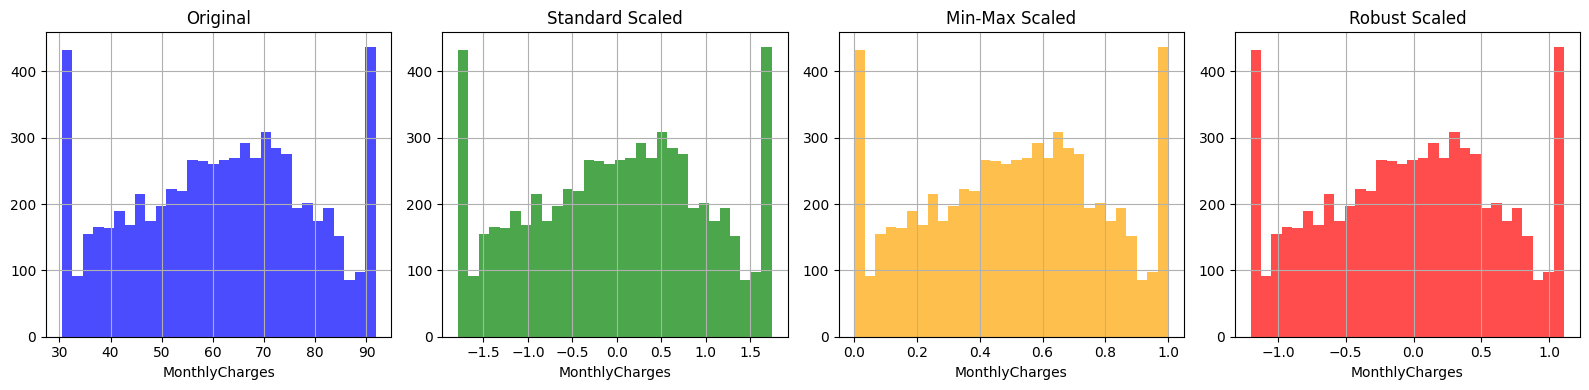


✅ Comparison visualization saved


In [25]:
print("\n" + "="*80)
print("STEP 5: COMPARE SCALING METHODS")
print("="*80)

# Select a sample feature to compare
feature = 'MonthlyCharges'

comparison_df = pd.DataFrame({
    'Original': df[feature],
    'StandardScaled': df_standard[feature],
    'MinMaxScaled': df_minmax[feature],
    'RobustScaled': df_robust[feature]
})

print(f"Comparison for '{feature}':")
print(comparison_df.describe())

# Visualize
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

comparison_df['Original'].hist(bins=30, ax=axes[0], color='blue', alpha=0.7)
axes[0].set_title('Original')
axes[0].set_xlabel(feature)

comparison_df['StandardScaled'].hist(bins=30, ax=axes[1], color='green', alpha=0.7)
axes[1].set_title('Standard Scaled')
axes[1].set_xlabel(feature)

comparison_df['MinMaxScaled'].hist(bins=30, ax=axes[2], color='orange', alpha=0.7)
axes[2].set_title('Min-Max Scaled')
axes[2].set_xlabel(feature)

comparison_df['RobustScaled'].hist(bins=30, ax=axes[3], color='red', alpha=0.7)
axes[3].set_title('Robust Scaled')
axes[3].set_xlabel(feature)

plt.tight_layout()
plt.savefig('scaling_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✅ Comparison visualization saved")

In [ ]:
print("\n" + "="*80)
print("MODELS THAT DON'T NEED SCALING")
print("="*80)

print("""
🚫 Tree-Based Models (NO SCALING NEEDED):
   • Decision Trees
   • Random Forest
   • Gradient Boosting (XGBoost, LightGBM, CatBoost)
   • AdaBoost

   Why? These models make split decisions based on thresholds,
   not distances. Feature scale doesn't matter!

✅ Models That NEED Scaling:
   • Logistic Regression
   • Support Vector Machines (SVM)
   • Neural Networks
   • K-Nearest Neighbors (KNN)
   • Linear Regression
   • Ridge/Lasso Regression

   Why? These models use distances or gradients,
   so feature scale directly impacts performance!
""")


MODELS THAT DON'T NEED SCALING

🚫 Tree-Based Models (NO SCALING NEEDED):
   • Decision Trees
   • Random Forest
   • Gradient Boosting (XGBoost, LightGBM, CatBoost)
   • AdaBoost
   
   Why? These models make split decisions based on thresholds,
   not distances. Feature scale doesn't matter!

✅ Models That NEED Scaling:
   • Logistic Regression
   • Support Vector Machines (SVM)
   • Neural Networks
   • K-Nearest Neighbors (KNN)
   • Linear Regression
   • Ridge/Lasso Regression
   
   Why? These models use distances or gradients,
   so feature scale directly impacts performance!



# **4. Feature Selection**

# **🔍 Step 1: Remove Low Variance Features**

💡 **Why Remove Low Variance Features:**

- **No information** — If all values are nearly the same, feature doesn't help  
- **Noise** — Can hurt model performance  
- **Efficiency** — Faster training with fewer features


In [26]:
print("\n" + "="*80)
print("FEATURE SELECTION")
print("="*80)

print("STEP 1: REMOVE LOW VARIANCE FEATURES")
print("="*80)

from sklearn.feature_selection import VarianceThreshold

# Select numerical features for variance analysis
numerical_cols = df_standard.select_dtypes(include=['int64', 'float64']).columns

# Calculate variance
variances = df_standard[numerical_cols].var()
low_variance_features = variances[variances < 0.01].index.tolist()

print(f"Features with variance < 0.01: {len(low_variance_features)}")
if len(low_variance_features) > 0:
    print("Low variance features to consider removing:")
    for feat in low_variance_features:
        print(f"   • {feat}: variance = {variances[feat]:.6f}")


FEATURE SELECTION
STEP 1: REMOVE LOW VARIANCE FEATURES
Features with variance < 0.01: 0


# **📊 Step 2: Correlation Analysis**

💡 **Why Remove Correlated Features:**

- **Multicollinearity** — Two features provide the same information  
- **Model complexity** — More features without more information  
- **Interpretation** — Harder to understand feature importance



STEP 2: IDENTIFY HIGHLY CORRELATED FEATURES
Found 50 highly correlated pairs (|r| > 0.9):
   • tenure ↔ AccountAgeYears: 1.000
   • tenure ↔ tenure_squared: 0.968
   • MonthlyCharges ↔ MonthlyCharges_squared: 0.989
   • DownloadSpeed ↔ UploadSpeed: 0.936
   • AccountAgeYears ↔ tenure_squared: 0.968
   • TotalServicesUsed ↔ TotalServices: 1.000
   • TotalServicesUsed ↔ TotalAddonServices: 0.963
   • TotalServicesUsed ↔ ServiceAdoptionRate: 1.000
   • TotalServices ↔ TotalAddonServices: 0.963
   • TotalServices ↔ ServiceAdoptionRate: 1.000
   • ChargePerService ↔ ServiceValueRatio: -0.909
   • HasFiberInternet ↔ InternetService_Fiber optic: 1.000
   • HasFiberInternet ↔ InternetService_Fiber optic: 1.000
   • HasFiberInternet ↔ InternetService_Fiber optic: 1.000
   • HasFiberInternet ↔ InternetService_Fiber optic: 1.000
   • TotalAddonServices ↔ ServiceAdoptionRate: 0.963
   • InternetService_Fiber optic ↔ InternetService_Fiber optic: 1.000
   • InternetService_Fiber optic ↔ InternetSer

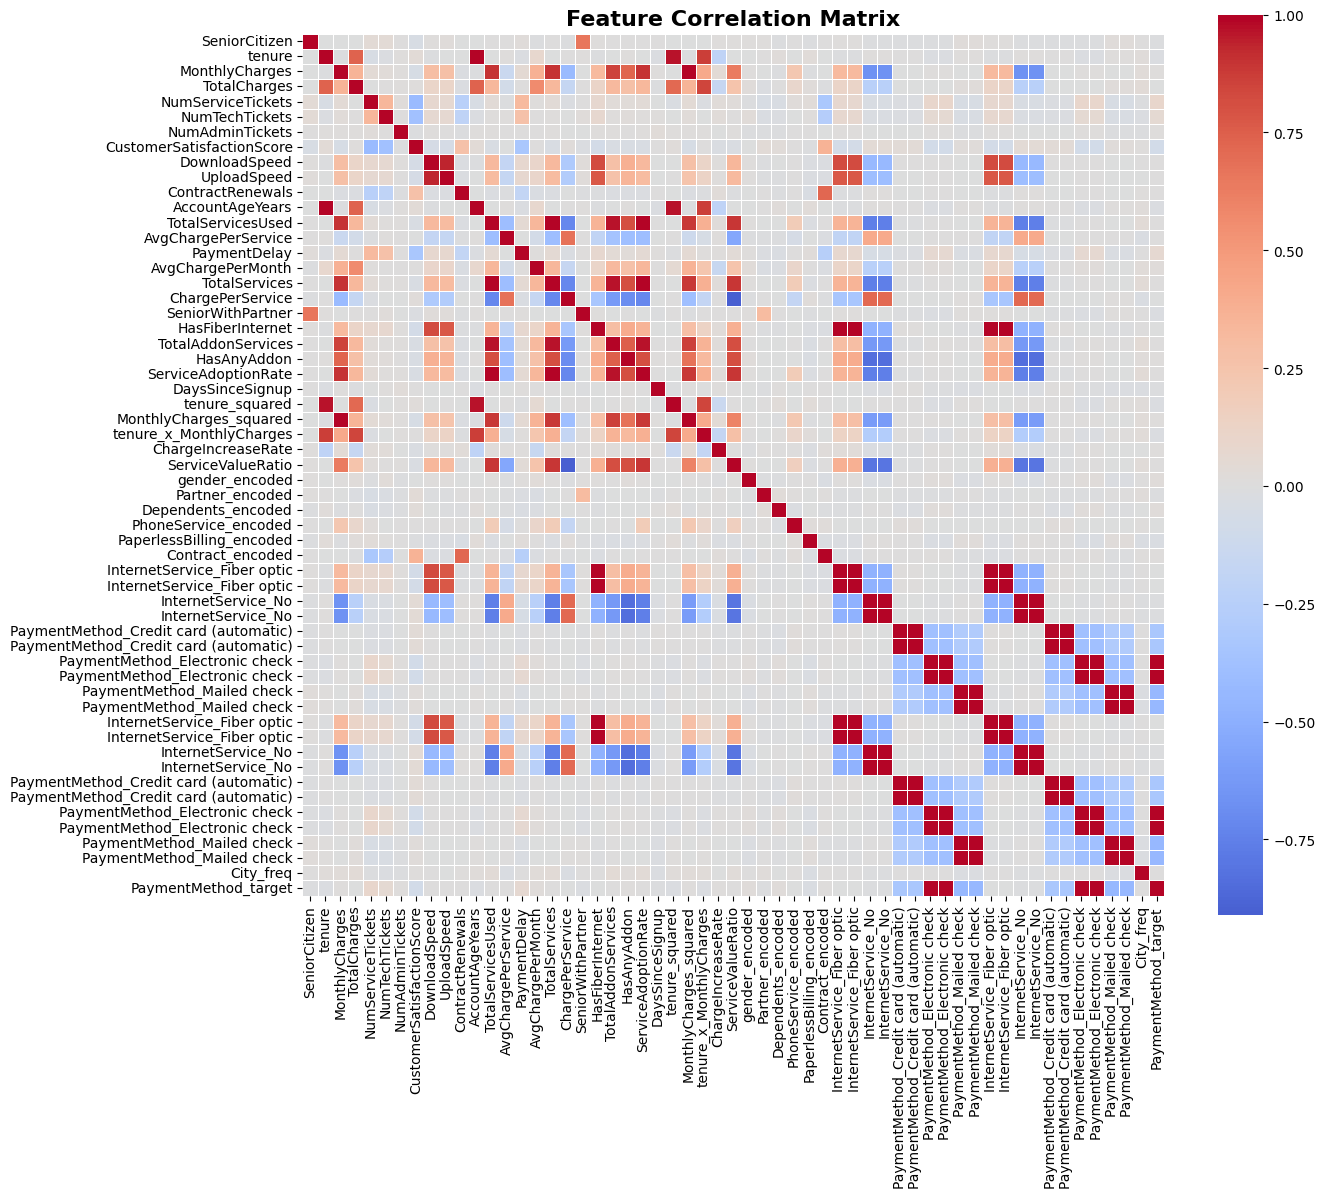


✅ Correlation matrix saved


In [27]:
print("\n" + "="*80)
print("STEP 2: IDENTIFY HIGHLY CORRELATED FEATURES")
print("="*80)

# Calculate correlation matrix
correlation_matrix = df_standard[numerical_cols].corr()

# Find highly correlated pairs (> 0.9)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

if len(high_corr_pairs) > 0:
    print(f"Found {len(high_corr_pairs)} highly correlated pairs (|r| > 0.9):")
    for pair in high_corr_pairs:
        print(f"   • {pair['Feature 1']} ↔ {pair['Feature 2']}: {pair['Correlation']:.3f}")
else:
    print("✅ No highly correlated feature pairs found")

# Visualize correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm',
            center=0, square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✅ Correlation matrix saved")

# **✅ Final Feature Set**

In [28]:
print("\n" + "="*80)
print("FINAL FEATURE SET")
print("="*80)

# For actual modeling, we'll use the standard scaled version
final_df = df_standard.copy()

print(f"Total features: {len(final_df.columns)}")
print(f"Numerical features: {len(numerical_cols)}")
print(f"Ready for modeling: ✅")

# Save final processed data
final_df.to_csv('data_ready_for_modeling.csv', index=False)
print("\n✅ Final processed data saved as 'data_ready_for_modeling.csv'")


FINAL FEATURE SET
Total features: 75
Numerical features: 47
Ready for modeling: ✅

✅ Final processed data saved as 'data_ready_for_modeling.csv'


In [29]:
print("\n" + "="*80)
print("PART 3 SUMMARY: FEATURE ENGINEERING & ENCODING")
print("="*80)

summary = """
✅ FEATURE ENGINEERING:
   • Created interaction features (e.g., AvgChargePerMonth)
   • Created aggregation features (e.g., TotalServices)
   • Created binning features (e.g., TenureGroup)
   • Extracted date features (e.g., SignupYear)
   • Created polynomial features (e.g., tenure_squared)
   • Created ratio features (e.g., ChargeIncreaseRate)

✅ ENCODING:
   • Binary encoding for binary features
   • Label encoding for ordinal features (Contract)
   • One-hot encoding for nominal features (InternetService)
   • Frequency encoding for high cardinality (City)
   • Target encoding demonstration (PaymentMethod)

✅ SCALING:
   • Standard Scaling (for SVM, Logistic Regression, Neural Networks)
   • Min-Max Scaling (for bounded ranges)
   • Robust Scaling (for data with outliers)

✅ FEATURE SELECTION:
   • Removed low variance features
   • Identified correlated features
   • Final feature set prepared

📁 FILES CREATED:
   • data_with_features.csv
   • data_encoded.csv
   • data_ready_for_modeling.csv
   • scaling_comparison.png
   • feature_correlation_matrix.png
"""

print(summary)

with open('Feature_Engineering_Report.txt', 'w') as f:
    f.write(summary)

print("✅ Report saved as 'Feature_Engineering_Report.txt'")


PART 3 SUMMARY: FEATURE ENGINEERING & ENCODING

✅ FEATURE ENGINEERING:
   • Created interaction features (e.g., AvgChargePerMonth)
   • Created aggregation features (e.g., TotalServices)
   • Created binning features (e.g., TenureGroup)
   • Extracted date features (e.g., SignupYear)
   • Created polynomial features (e.g., tenure_squared)
   • Created ratio features (e.g., ChargeIncreaseRate)

✅ ENCODING:
   • Binary encoding for binary features
   • Label encoding for ordinal features (Contract)
   • One-hot encoding for nominal features (InternetService)
   • Frequency encoding for high cardinality (City)
   • Target encoding demonstration (PaymentMethod)

✅ SCALING:
   • Standard Scaling (for SVM, Logistic Regression, Neural Networks)
   • Min-Max Scaling (for bounded ranges)
   • Robust Scaling (for data with outliers)

✅ FEATURE SELECTION:
   • Removed low variance features
   • Identified correlated features
   • Final feature set prepared

📁 FILES CREATED:
   • data_with_featur

## 🎓 **Key Takeaways**

### **What We Learned**
- **Feature Engineering** — Created meaningful new features from existing ones  
- **Encoding Methods** — Different techniques for different types of categorical data  
- **Feature Scaling** — When and how to scale features  
- **Feature Selection** — Identifying and removing redundant features  

---

### **Best Practices**
✅ **Domain knowledge** — Use business understanding to create features  
✅ **Test different encodings** — Compare which works best for your model  
✅ **Scale appropriately** — Know which models need scaling  
✅ **Avoid data leakage** — Never use test data for scaling/encoding decisions


# **🎉 Congratulations! You've completed Part 3: Feature Engineering & Encoding**